# 0. Import Required Packages

In [ ]:
# !pip install tscv

In [ ]:
import math
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import decomposition, datasets
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
import lightgbm as lgb
import pickle
import joblib
# from tscv import GapWalkForward
import gc
from tqdm import tqdm


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# For CV score calculation
def corr_score(pred, valid):
    len_data = len(pred)
    mean_pred = np.sum(pred) / len_data
    mean_valid = np.sum(valid) / len_data
    var_pred = np.sum(np.square(pred - mean_pred)) / len_data
    var_valid = np.sum(np.square(valid - mean_valid)) / len_data

    cov = np.sum((pred * valid))/len_data - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

# 1. Data Wrangling
## 1.1 Predictors

In [ ]:
data = pd.read_csv('./research_dataset_2022.csv', parse_dates=True, index_col=0)
spy = pd.read_csv('./SPY.csv', parse_dates=True, index_col=0)
data.dropna(subset=['trans_spy_open'], inplace=True)

data['DEF'] = data['BAA'] - data['AAA']
data['TERM'] = data['US10YR'] - data['US3M']
data['VRP'] = data['trans_VIX'] - data['garch']
#data['PCR'] = data['trans_spy_open'] / data['trans_SPGSCI']
data['PCR'] = np.log(spy['Open']) / data['trans_SPGSCI']
# the current price versus the past 10 month simple moving average.
#data['MA'] = data['trans_spy_open'] / data['trans_spy_open'].rolling(217).mean()
data['MA'] = np.log(spy['Open'] / spy['Open'].rolling(217).mean())

In [ ]:
# CAY
X = data[['Consumption_new', 'Income_new']][1800:]; Y = data['Assets_new'][1800:]
LR = LinearRegression().fit(X, Y)
residual = -(Y - LR.predict(X))
data['CAY'] = [np.nan] * 1800 + residual.to_list()

In [ ]:
# MOM
data['MOM'] = np.nan
for i in range(len(spy)):
    data['MOM'] = np.log(spy['Open'] / spy['Open'].shift(-12))

In [ ]:
# OBV
spy['OBV'] = np.nan
spy['OBV'].iloc[0] = spy.iloc[0]['Volume']
for i in range(1,len(spy)):
    if spy.iloc[i]['Close'] > spy.iloc[i-1]['Close']:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV'] + spy.iloc[i]['Volume']
    elif spy.iloc[i]['Close'] < spy.iloc[i-1]['Close']:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV'] - spy.iloc[i]['Volume']
    else:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV']
data['OBV'] = np.log(spy['OBV'])

In [ ]:
data = data.reset_index().rename(columns={'index':'Date'})

In [ ]:
data.head()

In [ ]:
var = data[['DividendToPriceRatio', 'trans_PE_RATIO', 'PxToBook', 'CAPE',
            'bbyield', 'DEF', 'TERM', 'CAY', 'SIM', 'VRP', 'IC', 'trans_BDIY',
            'NOS', 'CPI', 'PCR', 'MA', 'OBV', 'MOM', 'SI', 'trans_MVOLE', 
            'BER', 'NAPMPRIC', 'CATY', 'IND_PROD']]
var.rename(columns = {'DividendToPriceRatio':'DP', 'trans_PE_RATIO':'PE',
                      'PxToBook':'BM', 'bbyield':'BY', 'trans_BDIY':'BDI',
                      'trans_MVOLE':'MVOLE', 'IND_PROD':'IP'}, inplace = True)
# Replace NaN Values with Zeros
var = var.fillna(0)

In [ ]:
data.head()

## 1.2 Principle Component

In [ ]:
std_slc = StandardScaler()
pca = decomposition.PCA(n_components=1)

# PCA_Price
X_price = var.loc[:, ['DP','PE','BM','CAPE']]
X_price_std = std_slc.fit_transform(X_price)
PCA_price = pca.fit_transform(X_price_std)
var.insert(loc=4, column='PCA_Price', value=PCA_price)

# PCA Tech
X_tech = var.loc[:, ['MA','OBV','MOM']]
X_tech_std = std_slc.fit_transform(X_tech)
PCA_tech = pca.fit_transform(X_tech_std)
var.insert(loc=19, column='PCA_Tech', value=PCA_tech)

var = var.drop(['DP','PE','BM','CAPE', 'MA','OBV','MOM'], axis=1)

## 1.3 Correlation between Predictors

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(np.round(var.corr(), 2), mask=np.triu(np.ones_like(var.corr(), dtype=np.bool)), 
           cmap="PiYG", annot=True)

## 1.4 PCA to Aviod Multicollinearity

In [ ]:
# PCA_Econ
X_econ = var.loc[:, ['BY','IC','CPI','IP']]
X_econ_std = std_slc.fit_transform(X_econ)
PCA_econ = pca.fit_transform(X_econ_std)
var.insert(loc=19, column='PCA_Econ', value=PCA_econ)

# new PCA_Price
var['DP'] = data['DividendToPriceRatio']; var['PE'] = data['trans_PE_RATIO']
var['BM'] = data['PxToBook']; var['CAPE'] = data['CAPE']
X_price_new = var.loc[:, ['DP','PE','BM','CAPE', 'CATY']]
X_price_new_std = std_slc.fit_transform(X_price_new)
PCA_price_new = pca.fit_transform(X_price_new_std)
var.insert(loc=1, column='PCA_Price_New', value=PCA_price_new)

var = var.drop(['BY','IC','CPI','IP', 'DP','PE','BM','CAPE', 'CATY', 'PCA_Price'], axis=1)

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(np.round(var.corr(), 2), mask=np.triu(np.ones_like(var.corr(), dtype=np.bool)), 
           cmap="PiYG", annot=True)

In [ ]:
data_ori = pd.concat([data['Date'], var], axis=1)

## 1.5 Extra Features Processing

In [ ]:
# -*- coding: utf-8 -*-
# Create new features
import pandas as pd
import numpy as np
import time

class FeatureWorkerClass(object):
    def __init__(self, target_code):
        self.target_col = target_code
        
    # define function to compute log returns
#     @staticmethod
#     def create_log_return(df, target_col, periods=1):
#         return_df = df.copy()
# #         return_df['log_return'] = np.log(return_df[target_col]).diff(periods=periods).shift(-1)
#         return_df['log_return'] = return_df[target_col].diff(periods=periods).shift(-1)
# #         return_df['log_return'] = return_df[target_col].diff(periods=periods)
#         return return_df
#     @staticmethod
#     def create_log_return(df, target_col, days=7, periods=1):
#         return_df = df.copy()
# #         return_df['log_return'] = np.log(return_df[target_col]).diff(periods=periods).shift(-1)
#         return_df['log_return'] = np.log(return_df[target_col] / return_df[target_col].shift(-days))
# #         return_df['log_return'] = return_df[target_col].diff(periods=periods)
#         return return_df
    @staticmethod
    def create_return(df, target_col, days=130, periods=1):
        return_df = df.copy()
#         return_df['log_return'] = np.log(return_df[target_col]).diff(periods=periods).shift(-1)
        return_df[f'{days}_return'] = (return_df[target_col].shift(-days) - return_df[target_col]) / return_df[target_col]
#         return_df['log_return'] = return_df[target_col].diff(periods=periods)
        return return_df
    
    # create log_close/mean features
    @staticmethod
    def create_log_close_mean_features(df, target_col, lags=[2, 3, 5, 10, 20, 30]):
        lcm_df = df.copy()
        for lag in lags:
            lcm_df[f'log_close/mean_{lag}'] = np.log( np.array(lcm_df[target_col]) \
                                                     / np.roll(np.append(np.convolve( np.array(lcm_df[target_col]), \
                                                                                     np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1))
            
            lcm_df[f'log_return_{lag}'] = np.log(np.array(lcm_df[target_col]) \
                                                    /  np.roll(np.array(lcm_df[target_col]), lag))
        return lcm_df

    # create lag features
    @staticmethod
    def create_lag_features(df, target_col, lags):
        lag_df = df.copy()
        for i in lags:
            lag_df[f'{target_col}_lag_{i}'] = lag_df[target_col].shift(i).values
        return lag_df

    # create rolling features: mean, max, min, median, std
    @staticmethod
    def create_rolling_features(df, target_col, windows, min_periods=1, shift=1):
        rolling_shift_df = df.copy()
        for w in windows:
            shift_df = rolling_shift_df[target_col].shift(shift).rolling(
                window=w, 
                min_periods=min_periods
                ).agg([ 'max', 'mean', 'min', 'median', np.nanstd], axis=1
                ).rename(columns={
                        'max': "_rmax_{}".format(w),
                        'mean': "_rmean_{}".format(w),
                        'min': "_rmin_{}".format(w),
                        'median': "_rmedian_{}".format(w),
                        'nanstd': "_rstd_{}".format(w),
                        }).reset_index()
            shift_df.columns = [''.join(col) for col in shift_df.columns]
            del shift_df['index']
            rolling_shift_df[list(shift_df.columns)] = shift_df
            
        return rolling_shift_df

    # create rolling skew features
    @staticmethod
    def create_rskew_features(df, target_col, windows, min_periods=2, shift=1):
        rolling_rskew_df = df.copy()
        for w in windows:
            rolling_rskew_df[f'{target_col}_rskew_{w}'] = \
                rolling_rskew_df[target_col].shift(shift).rolling(
                    window=w,
                    min_periods=min_periods
                ).skew().fillna(0).values
        return rolling_rskew_df

    # create diff features
    @staticmethod
    def create_diff_features(df, target_col, periods=[1], shift=1):
        diff_df = df.copy()
        for p in periods:
            diff_df[f'{target_col}_diff_{p}'] = \
                diff_df[target_col].shift(shift).diff(periods=p).abs().values
        return diff_df

    # create percentage change features
    @staticmethod
    def create_pct_change_features(df, target_col, periods=[1], shift=1):
        pct_change_df = df.copy()
        for p in periods:
            pct_change_df[f'{target_col}_pct_change_{p}'] = \
                pct_change_df[target_col].shift(shift).pct_change(periods=p).replace(np.inf,0).fillna(0).abs().values
        return pct_change_df

    # Creating exponentially weighted mean features
    @staticmethod
    def create_ewm_features(df, target_col, alpha=[0.9], shift=[1]):
        ewm_df = df.copy()
        for a in alpha:
            for s in shift:
                ewm_df[f'{target_col}_ewm_{a}_{s}'] = \
                    ewm_df[target_col].shift(s).ewm(alpha=a).mean().values
        return ewm_df
    
    @staticmethod
    def create_kdj_features(df, target_col, min_periods=2, windows=[10], com=[2], shift=1):
        kdj_df = df.copy()
        for c in com:
            for w in windows:
                lowest = kdj_df[target_col].shift(shift).rolling(window=w, min_periods=min_periods).min()
                highest = kdj_df[target_col].shift(shift).rolling(window=w, min_periods=min_periods).max()
                rsv = (kdj_df[target_col].shift(shift) - lowest) / (highest - lowest) * 100
                rsv.fillna(value = 100.0, inplace=True)

                k = rsv.ewm(com=c, adjust=False).mean()
                kdj_df[f'{target_col}_kdj_{c}_{w}'] = 3 * k - 2 * k.ewm(com=c, adjust=False).mean()
        return kdj_df
    
    @staticmethod
    def create_normal_features(df):
        n_df = df.copy()
        n_df['Upper_Shadow'] = n_df['High'] - np.maximum(n_df['Close'], n_df['Open'])
        n_df['Lower_Shadow'] = np.minimum(n_df['Close'], n_df['Open']) - n_df['Low']
        # n_df['hlco_ratio'] = (n_df['High'] - n_df['Low'])/(n_df['Close'] - n_df['Open']+1)
        return n_df
        
    def create_origin_features(self, df):
        matrix_df = df.copy()
        
        matrix = self.create_lag_features(df=matrix_df,
                                                    target_col=self.target_col,
                                                    lags=[1])
        print("lag feature over.......................") 
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        
    def create_return_features(self, df):
        matrix_df = df.copy()
        
        matrix_df = self.create_return(df=matrix_df,
                                            target_col=self.target_col
                                                       )
        print("return feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        
        return matrix_df
        
        
    
    def create_lag_return_features(self, df):
        matrix_df = df.copy()
        
        
        matrix_df = self.create_lag_features(df=matrix_df,
                                             target_col=self.target_col,
                                             lags=[1,2,3,4,5,6,7])
        print("lag feature over.......................") 
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))

 
        matrix_df = self.create_rolling_features(df=matrix_df,
                                                    target_col=self.target_col,
                                                    shift=0,
                                                    windows=[2, 3, 4, 8, 12, 16, 30])
        print("rolling feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        matrix_df = self.create_log_close_mean_features(df=matrix_df,
                                                    target_col=self.target_col,
                                                    lags=[2, 3, 5, 10, 20, 30]
                                                       )
        print("log_close_mean feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))

        matrix_df = self.create_pct_change_features(df=matrix_df,
                                                    target_col=self.target_col,
                                                    shift=0,
                                                    periods=[1, 2, 3, 4, 8, 12, 16, 30])
        print("pct change feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))


        matrix_df = self.create_ewm_features(df=matrix_df,
                                             target_col=self.target_col,
                                             alpha=[0.8, 0.5],
                                             shift=[3, 4, 8, 12, 16, 30])
        print("ewm feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        matrix_df = self.create_rskew_features(df=matrix_df,
                                             target_col=self.target_col,
                                             windows=[4, 8, 12, 16, 48], 
                                             min_periods=2, 
                                             shift=0)
        print("rskew feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        matrix_df = self.create_kdj_features(df=matrix_df,
                                             target_col=self.target_col,
                                             min_periods=2, 
                                             windows=[7, 10, 20, 30], 
                                             com=[1, 2],
                                             shift=0)
        print("kdj feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        return matrix_df

##### lag features

- Params: lag days

- The return value of N day before.

##### Rolling features
- Params: windows
- max/min/mean/std of past N days' return

#### log_close_mean features

- Params: periods

- log_close_mean_period = $\frac{log(Close_t)}{mean(Close_{t-period,t})}$
- log_return_period = $log(Close_t) - log(Close_{t-period})$



#### PCT change features

- Params: periods
- pct_change_period = $\frac{Close_t-Close_{t-period}}{Close_{t-period}}$


#### EWM features

- Params: shift, alpha
- ewm_alpha_shift = $\frac{Close_{t-shift}+(1-\alpha)Close_{t-shift-1}+(1-\alpha)^2Close_{t-shift-2}+...+(1-\alpha)^{t-shift}Close_0}{1+(1-\alpha)+(1-\alpha)^2+...+(1-\alpha)^{t-shift}}$

#### rskew features
- Params: windows
- return the rolling skew from $Close_t$ to $Close_{t-window}$ 


#### KDJ features
- Params: com, windows
- $RSV_t = \frac{Close_t-Lowest_t}{Highest_t-lowest_t}*100$
- $K_t = (1-\frac{1}{1+com})K_{t-1}+\frac{1}{1+com}RSV_t$

In [ ]:
spy = pd.read_csv('./SPY.csv', parse_dates=True, index_col=0)
spy = spy.reset_index()

In [ ]:
spy_log = FeatureWorkerClass('Close').create_return_features(spy.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)).drop(['Close'], axis=1)
spy_log['year'] = spy_log['Date'].apply(lambda x: int(str(x)[0:4]))
spy_log['month'] = spy_log['Date'].apply(lambda x: int(str(x)[5:7]))
spy_log['day'] = spy_log['Date'].apply(lambda x: int(str(x)[8:10]))

Drop last 130 days.

In [ ]:
spy_log = spy_log.iloc[:-130, :]

In [ ]:
spy_log.tail()

Create upper shadow and lower shadow features

In [ ]:
matrix_df = FeatureWorkerClass('Close').create_normal_features(spy)

Create extra features on 'Close'

In [ ]:
matrix_df = FeatureWorkerClass('Close').create_lag_return_features(matrix_df).drop(['Open', 'High', 'Low', 'Close'], axis=1)

In [ ]:
matrix_df.tail()

In [ ]:
data_ori.tail()

Merge all data together on 'Date'

In [ ]:
mg = pd.merge(data_ori, spy_log, on=['Date'])
mg = pd.merge(mg, matrix_df, on=['Date'])
# mg = pd.merge(matrix_df, spy_log, on=['Date'])

In [ ]:
# sorted(mg.corr()['130_return'].items(), key=lambda x: abs(x[1]), reverse=True)

In [ ]:
mg.tail()

In [ ]:
df = mg.copy()

X = df.iloc[30:].drop(['130_return'], axis=1)
y = df.iloc[30:][['130_return']]

## 2. Training

In [ ]:
# define features for LGBM
not_use_features_train = ['Date']

features = X.columns 
features = features.drop(not_use_features_train)
features = list(features)
# display(features)  
len(features)

### 2.1 LGBM

Plot lightgbm-cv-feature-importance

In [ ]:
# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(importances, features_names = features, PLOT_TOP_N = 20, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

LGBM CV

In [ ]:
def kf_lgbm(F, X_train, y_train):
    seed0 = 0
    params = {
        'early_stopping_rounds': 50,
        'objective': 'regression',
        'metric': 'rmse',
    #     'metric': 'None',
        'boosting_type': 'gbdt',
        'max_depth': 5,
        'verbose': -1,
        'max_bin':600,
        'min_data_in_leaf':50,
        'learning_rate': 0.03,
        'subsample': 0.8,
        'subsample_freq': 1,
        'feature_fraction': 1,
        'lambda_l1': 0.5,
        'lambda_l2': 1,
        'seed':seed0,
        'feature_fraction_seed': seed0,
        'bagging_fraction_seed': seed0,
        'drop_seed': seed0,
        'data_random_seed': seed0,
        'extra_trees': True,
        'extra_seed': seed0,
        'zero_as_missing': True,
        "first_metric_only": True,
#         "device": "gpu",
#         "gpu_platform_id": 0,
#         "gpu_device_id": 0,
             }
    fold = F
    # cv = GapWalkForward(n_splits=fold, gap_size=100, test_size=22)
    cv = KFold(n_splits = fold, random_state = 2021, shuffle = True)
    importances = []
    oof_pred = []
    oof_valid = []
    for split, train_test_split in enumerate(cv.split(X_train)):
        gc.collect()
        train_index, val_index = train_test_split
    #     train_X, train_Y = X_train.iloc[train_index, :].copy(), y_train.iloc[train_index, :].copy()
    #     val_X, val_Y = X_train.iloc[val_index, :].copy(), y_train.iloc[val_index, :].copy()
    #     print(train_X.tail())
        train_dataset = lgb.Dataset(X_train.iloc[train_index, 1:],
                                        y_train.iloc[train_index, :].values, 
                                        feature_name = features, 
                                       )
        val_dataset = lgb.Dataset(X_train.iloc[val_index, 1:], 
                                      y_train.iloc[val_index, :].values, 
                                      feature_name = features, 
                                     )
        print(f"number of train data: {len(X_train.iloc[train_index])}")
        print(f"number of val data:   {len(X_train.iloc[val_index])}")
        model = lgb.train(params = params,
                              train_set = train_dataset, 
                              valid_sets=[train_dataset, val_dataset],
                              valid_names=['tr', 'vl'],
                              num_boost_round = 10000,
                              verbose_eval = 2000,     
    #                           feval = rmse,
                             )
        importances.append(model.feature_importance(importance_type='gain'))
        file = f'trained_model_fold{split}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print(f"Trained model was saved to 'trained_model_fold{split}.pkl'")
        print("")

#         oof_pred += list(model.predict(X_train.iloc[val_index, 1:]))
#         oof_valid += list(y_train.iloc[val_index, :].values)


#     plot_importance(np.array(importances),features, PLOT_TOP_N = 20, figsize=(10, 5))
    return model



In [ ]:
def rolling_predict(X, y, tr_num, test_num):
    all_pred = list()
    all_y = list()
    for i in tqdm(range(int(len(X.iloc[tr_num:])/test_num))):
        print('Train data num: {}'.format(tr_num))
        print('Test data num: {}'.format(test_num))
        num = i * test_num
        train_X = X.iloc[num:tr_num+num]
        train_y = y.iloc[num:tr_num+num]
        test_X = X.iloc[tr_num+num:tr_num+num+test_num]
        test_y = y.iloc[tr_num+num:tr_num+num+test_num]
#         print(test_X.head())
        if num % 30 == 0:
            fold = 5
            kf_lgbm(fold, train_X, train_y)
        pred = []
        for i in range(fold):
            model = joblib.load(f"./trained_model_fold{i}.pkl")
            pred.append(model.predict(test_X.iloc[:, 1:]))
        y_pred = np.mean(pred, axis=0)
        
        all_pred += list(y_pred)
        all_y += list(test_y.values)
    return all_pred, all_y
        
    
    

In [ ]:
all_pred, all_y = rolling_predict(X, y, 2600, 1)

lgbm rmse: 0.004507974907238488
lgbm r sqaure: 0.6205593231357102


<AxesSubplot:xlabel='Date', ylabel='value'>

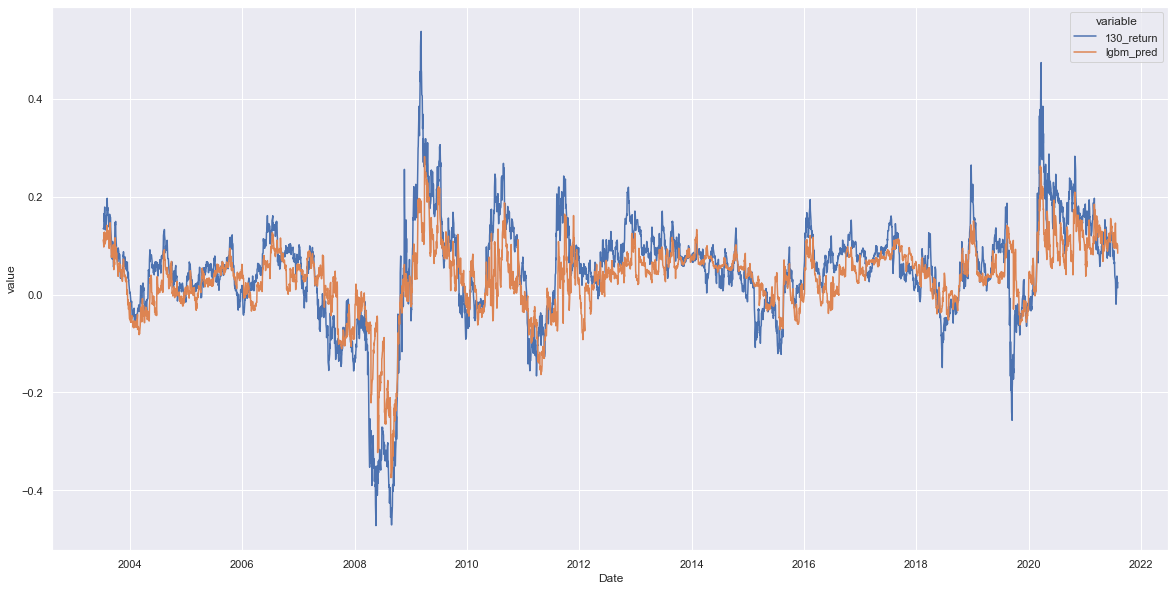

In [169]:
tmp = y.iloc[2600:7256].copy()
# tmp.rename()
# tmp = pd.DataFrame()
# tmp['22_return'] = list(y.iloc[6000:7254].values)
tmp['lgbm_pred'] = all_pred
tmp['Date'] = X.iloc[2600:]['Date']
lgbm_rmse = mse(all_y, all_pred)
lgbm_r2 = r2_score(all_y, all_pred)
print('lgbm rmse: {}'.format(lgbm_rmse))
print('lgbm r sqaure: {}'.format(lgbm_r2))
ml = pd.melt(tmp, id_vars=['Date'])
plt.figure(figsize=(20, 10))
sns.lineplot(data=ml, x='Date', y='value', hue='variable')

### CV LGBM feature importance boxplot

In [ ]:
importances = list()
for i in range(5):
    model = joblib.load(f"./trained_model_fold{i}.pkl")
    importances.append(model.feature_importance(importance_type='gain'))
plot_importance(np.array(importances),features, PLOT_TOP_N = 30, figsize=(20, 10))

In [ ]:
def predict_y(model, X, y, tr_num, test_num):
    all_pred = list()
    all_y = list()
    for i in tqdm(range(int(len(X.iloc[tr_num:])/test_num))):
        print('Train data num: {}'.format(tr_num))
        print('Test data num: {}'.format(test_num))
        num = i * test_num
        train_X = X.iloc[num:tr_num+num, 1:].values
        train_y = y.iloc[num:tr_num+num].values
        test_X = X.iloc[tr_num+num:tr_num+num+test_num, 1:].values
        test_y = y.iloc[tr_num+num:tr_num+num+test_num].values
        if num % 22 == 0:
             model.fit(train_X, train_y)
        y_pred = model.predict(test_X)
        # print(y_pred)
        try:
            all_pred.extend(list(y_pred[0]))
        except:
            all_pred.append(y_pred[0])
        all_y.extend(test_y)
    return all_pred, all_y

In [175]:
# l = pd.DataFrame()
# l['Date'] = X.iloc[2600:7256]['Date']
# l['lgbm_pred'] = all_pred
# l.to_csv('./lgbm_pred.csv', index=0)

### 2.2 Kitchen Sinking Regression

In [ ]:
lr = LinearRegression()
lr_pred, _ = predict_y(lr, X, y, 2600, 1)

lr rmse: 0.00831672216677558
lr r sqaure: 0.29997332434427815


<AxesSubplot:xlabel='Date', ylabel='value'>

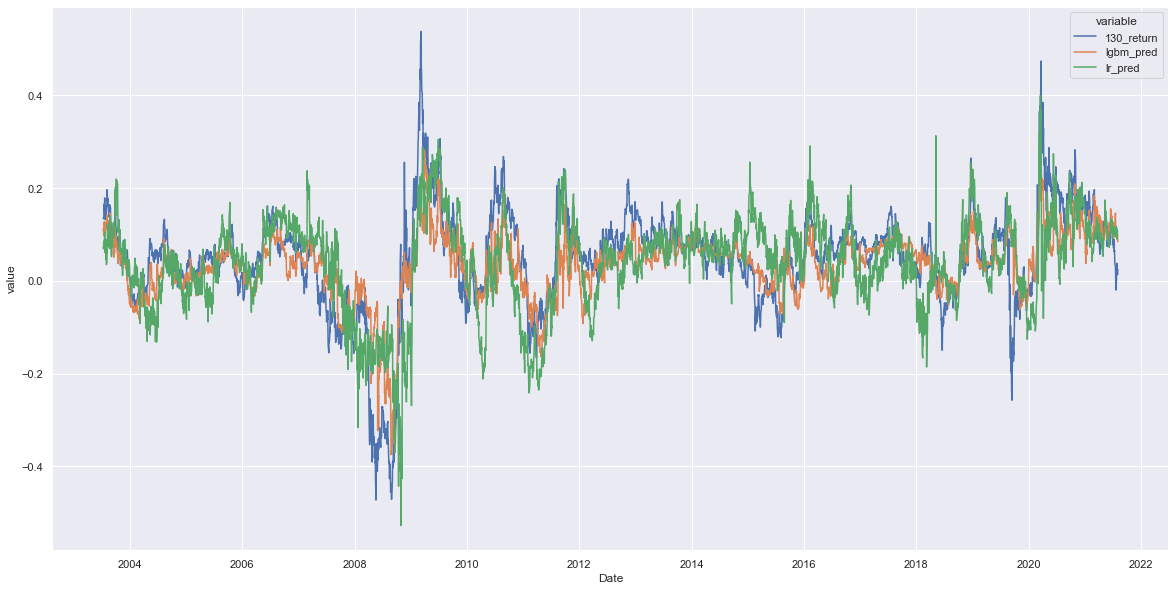

In [177]:
# tmp = y.iloc[6000:7256].copy()
# tmp = pd.DataFrame()
# tmp['22_return'] = list(y.iloc[6000:7254].values)
tmp['lr_pred'] = lr_pred
lr_rmse = mse(all_y, lr_pred)
lr_r2 = r2_score(all_y, lr_pred)
print('lr rmse: {}'.format(lr_rmse))
print('lr r sqaure: {}'.format(lr_r2))
ml = pd.melt(tmp, id_vars=['Date'])
plt.figure(figsize=(20, 10))
sns.lineplot(data=ml, x='Date', y='value', hue='variable')

### 2.3 Correlation Screening

In [ ]:
corr = sorted(abs(round(pd.concat([X, y], axis=1).corr()['130_return'], 3)).items(), key=lambda x: x[1], reverse=True)

In [ ]:
X_cs = X[[c[0] for c in corr[1:31]]]
cs = LinearRegression()
cs_pred, _ = predict_y(cs, X_cs, y, 2600, 1)

cs rmse: 0.007754335958259561
cs r sqaure: 0.3473099240391466


<AxesSubplot:xlabel='Date', ylabel='value'>

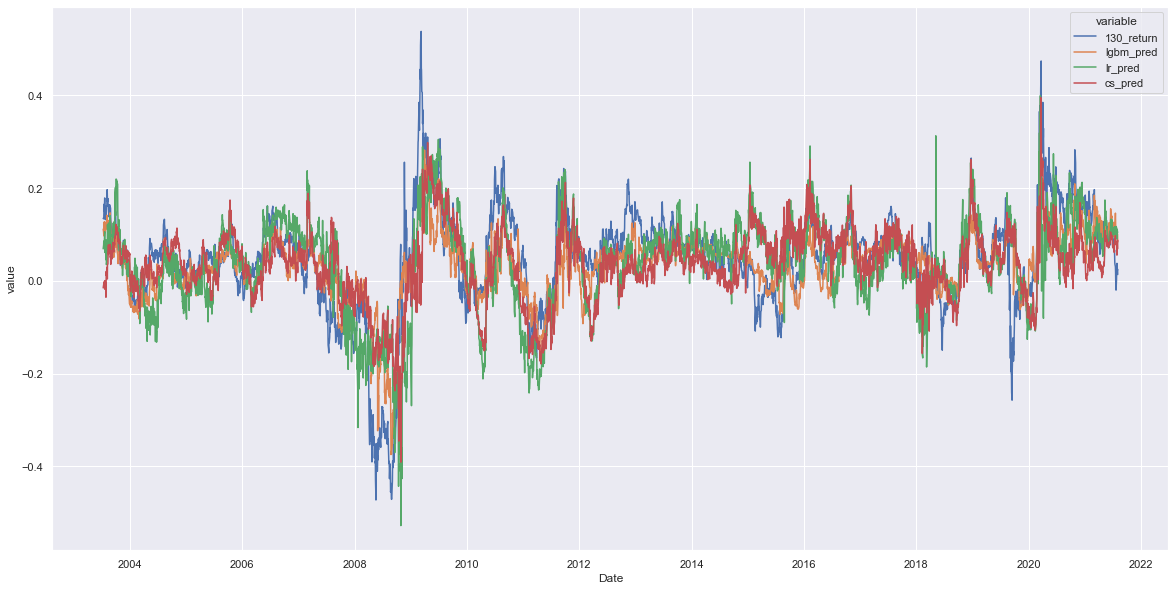

In [178]:
tmp['cs_pred'] = cs_pred
cs_rmse = mse(all_y, cs_pred)
cs_r2 = r2_score(all_y, cs_pred)
print('cs rmse: {}'.format(cs_rmse))
print('cs r sqaure: {}'.format(cs_r2))
ml = pd.melt(tmp, id_vars=['Date'])
plt.figure(figsize=(20, 10))
sns.lineplot(data=ml, x='Date', y='value', hue='variable')

### 2.4 LASSO Regression

In [ ]:
# X_col = var.columns.drop(['1MReturn', '3MReturn', '6MReturn', '1YReturn'])
# X_scaled = std_slc.fit_transform(X.iloc[:, 1:])
# X_scaled = pd.DataFrame(data = X_scaled, columns = X.iloc[:, 1:].columns)

# cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
cv = KFold(n_splits=5, random_state = 2021, shuffle = True)
lasso_alphas = np.linspace(0.01, 0, 20)
lasso = LassoCV(alphas=lasso_alphas, cv=cv, n_jobs=-1)
# lasso_pred = []
# predict_y(lasso, lasso_pred, X_scaled)
lasso_pred, _ = predict_y(lasso, X, y, 2600, 1)

lasso rmse: 0.007942009194474818
lasso r sqaure: 0.33151328336475316


<AxesSubplot:xlabel='Date', ylabel='value'>

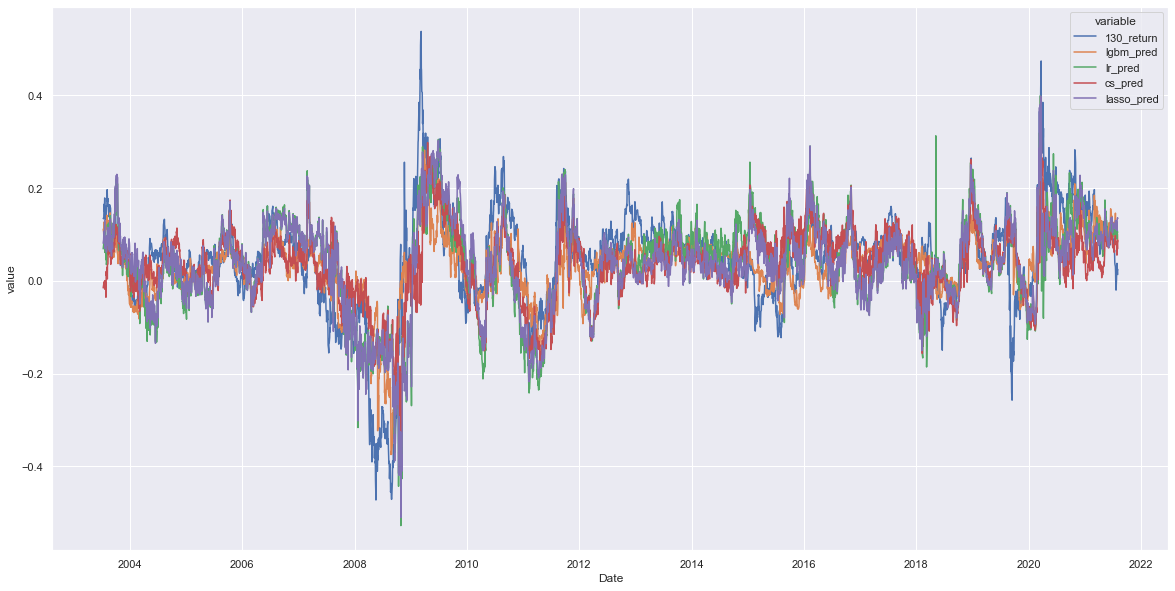

In [179]:
tmp['lasso_pred'] = lasso_pred
lasso_rmse = mse(all_y, lasso_pred)
lasso_r2 = r2_score(all_y, lasso_pred)
print('lasso rmse: {}'.format(lasso_rmse))
print('lasso r sqaure: {}'.format(lasso_r2))
ml = pd.melt(tmp, id_vars=['Date'])
plt.figure(figsize=(20, 10))
sns.lineplot(data=ml, x='Date', y='value', hue='variable')

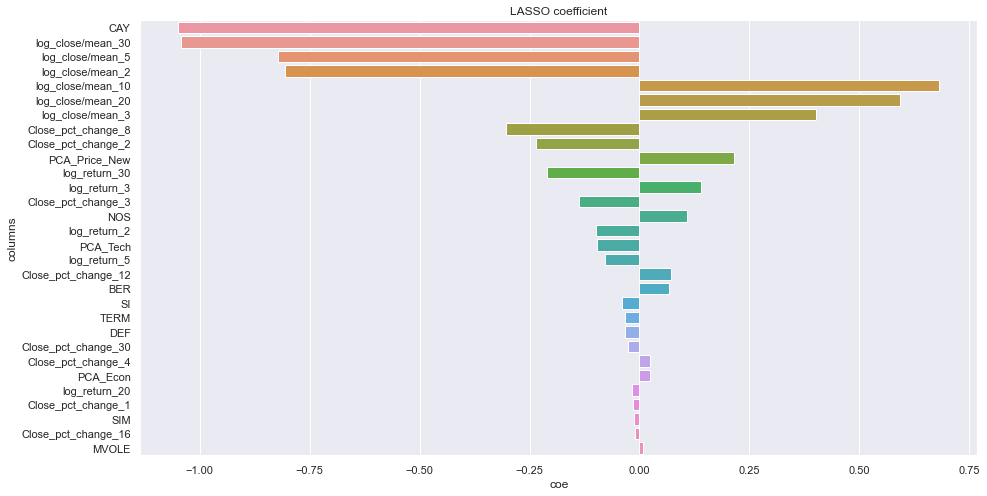

In [180]:
ls  = pd.DataFrame()
ls['coe'] = lasso.coef_
ls['abs_coe'] = abs(lasso.coef_)
ls['columns'] = X.iloc[:, 1:].columns
ls = ls.sort_values(by='abs_coe', ascending=False).iloc[:30]
g = sns.barplot(x="coe", y="columns", data=ls)
g.set_title('LASSO coefficient')
plt.savefig('./figure/lasso_coe.png')

## 3. Actual vs. Forecast Returns

### 3.1 cum_sum

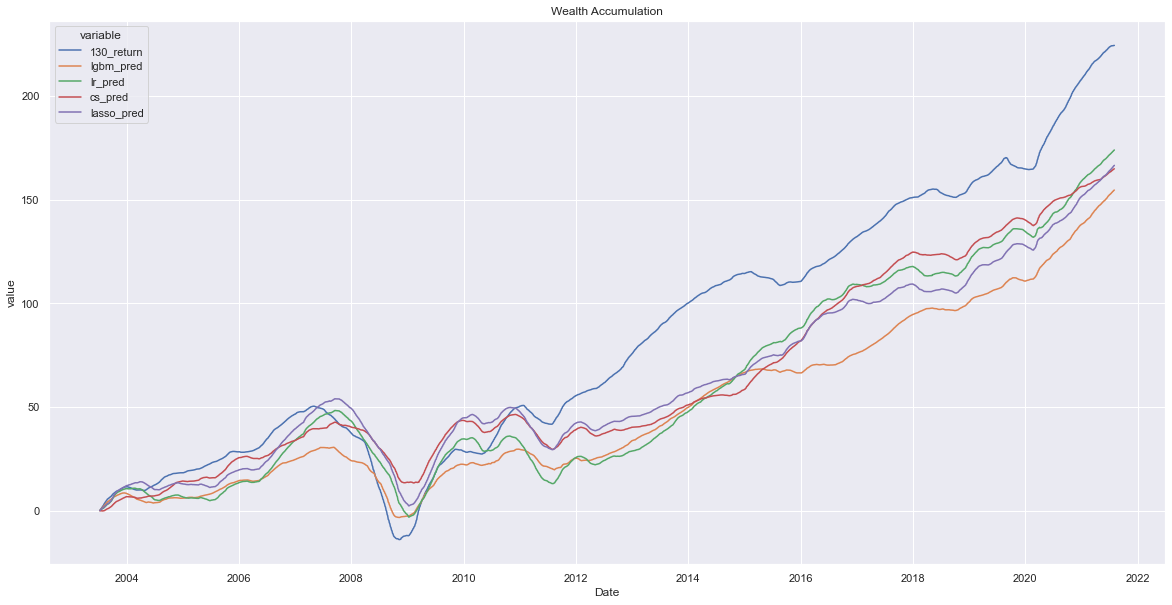

In [181]:
count = tmp.copy()
count = count.drop(['Date'], axis=1).cumsum()
count['Date'] = tmp['Date']
ml_count = pd.melt(count, id_vars=['Date'])
plt.figure(figsize=(20, 10))
g = sns.lineplot(data=ml_count, x='Date', y='value', hue='variable')
g.set_title('Wealth Accumulation')
plt.savefig('./figure/accumulation.png')

### 3.2 RMSE & R2

In [182]:
rr = pd.DataFrame()
rr['model'] = ['LGBM', 'LR', 'CS', 'LASSO']
rr['RMSE'] = [lgbm_rmse, lr_rmse, cs_rmse, lasso_rmse]
rr['R2'] = [lgbm_r2, lr_r2, cs_r2, lasso_r2]
rr

,model,RMSE,R2
0,LGBM,0.004508,0.620559
1,LR,0.008317,0.299973
2,CS,0.007754,0.347310
3,LASSO,0.007942,0.331513


### 3.3 Position(8 times)

In [241]:
def position_plot(df, model_name, color):
    tmp_cp = df[['Date', '130_return', f'{model_name}_pred']].copy()
    plt.figure(figsize=(30, 5))
    tmp_cp[f'{model_name}_pred'] = tmp_cp[f'{model_name}_pred'] * 8
    tmp_cp[f'{model_name}_pred'] = tmp_cp[f'{model_name}_pred'].apply(lambda x: 1.5 if x > 1.5 else x)
    tmp_cp[f'{model_name}_pred'] = tmp_cp[f'{model_name}_pred'].apply(lambda x: -0.5 if x < -0.5 else x)
    g = sns.lineplot(data=tmp_cp, x='Date', y=f'{model_name}_pred', color=f"{color}")
    plt.axhline(y=1, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dashed')
    g.set_title(f'{model_name.upper()} Position')
    # plt.legend()
    plt.savefig(f'./figure/{model_name}_position.png')

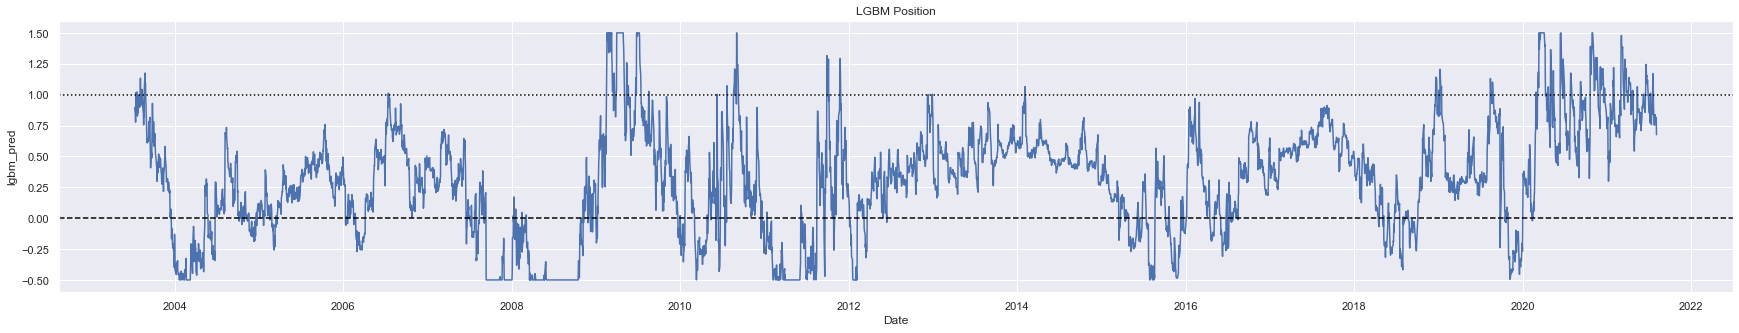

In [242]:
position_plot(tmp, 'lgbm', 'b')

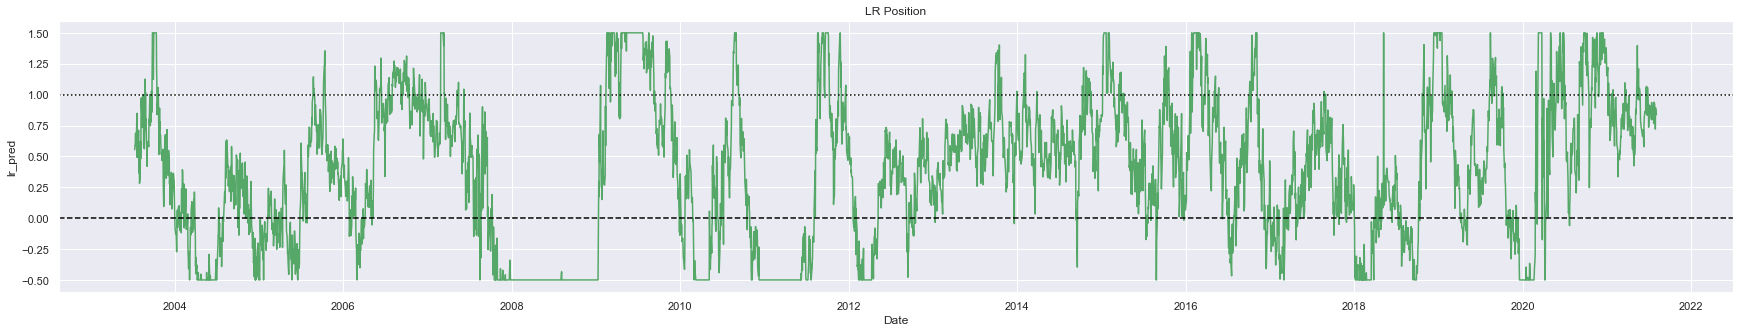

In [243]:
position_plot(tmp, 'lr', 'g')

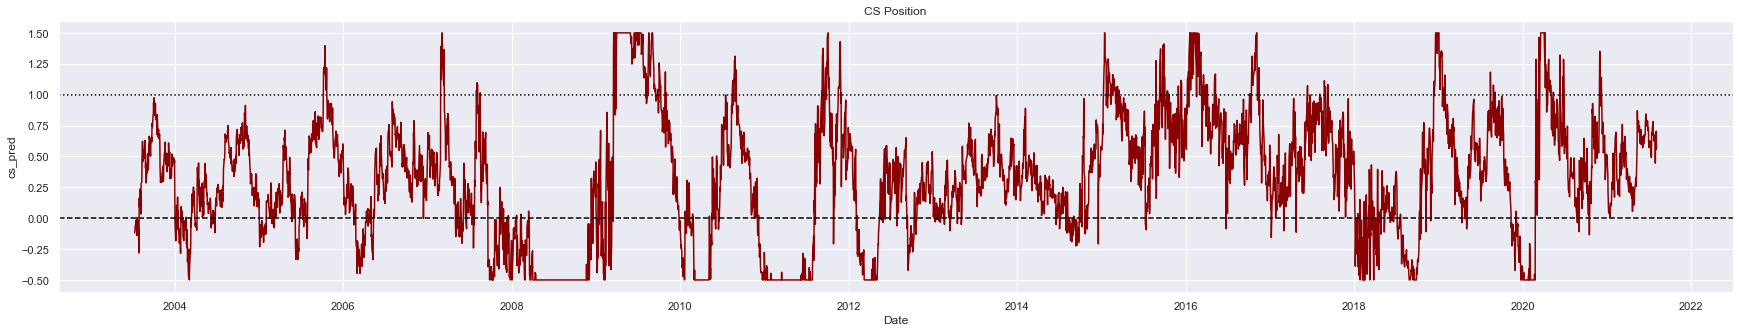

In [245]:
position_plot(tmp, 'cs', 'darkred')

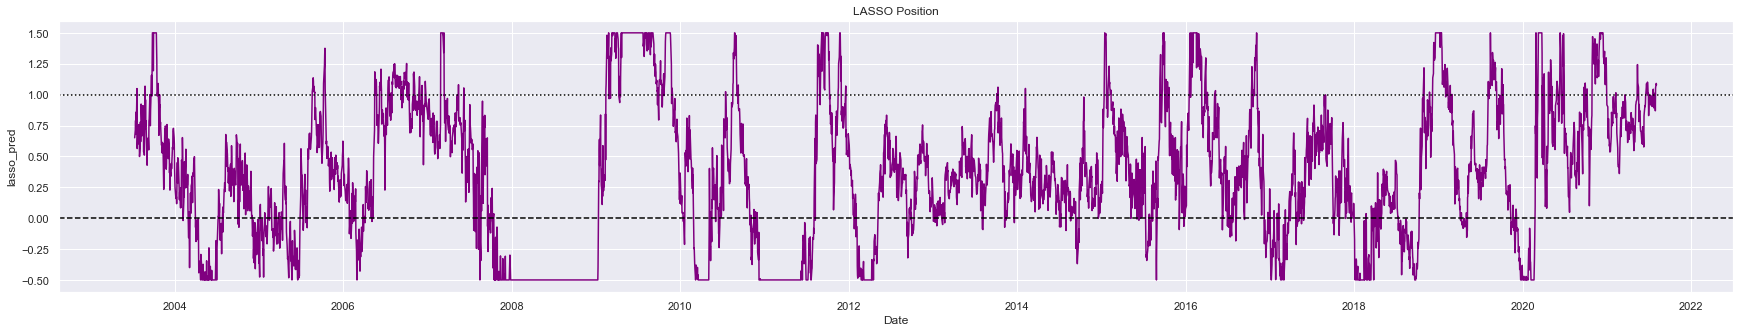

In [247]:
position_plot(tmp, 'lasso', 'purple')

### 3.4 Regplot

In [248]:
def reg_plot(df, model_name, color):
    plt.figure(figsize=(10, 10))
    g = sns.regplot(x="130_return", y=f"{model_name}_pred", data=df,
                    color=f"{color}")
    plt.axis('equal')
    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.axvline(x=0, color='black', linestyle='dashed')
    plt.axline([0, 0], [0.1, 0.1], color='black', linestyle='dashed')
    g.set_title(f'{model_name.upper()} Model')
    plt.savefig(f'./figure/{model_name}_vs.png')

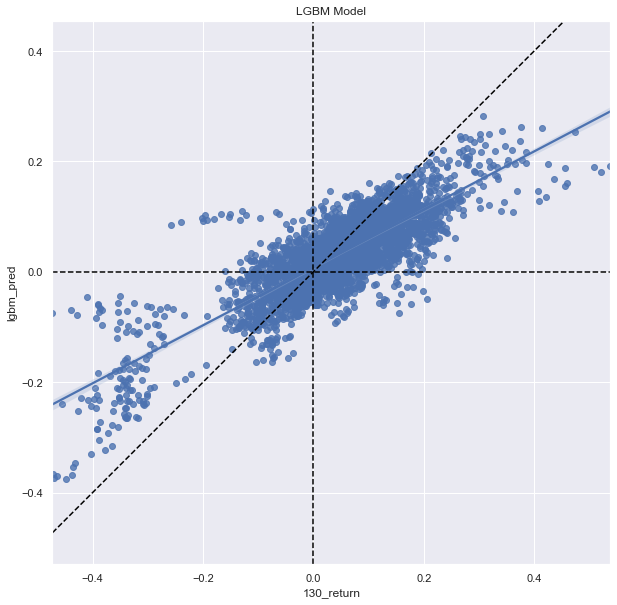

In [249]:
reg_plot(tmp, 'lgbm', 'b')

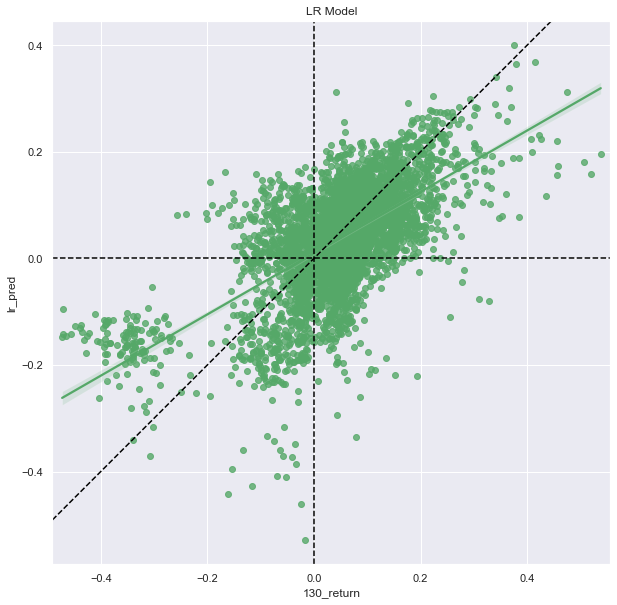

In [250]:
reg_plot(tmp, 'lr', 'g')

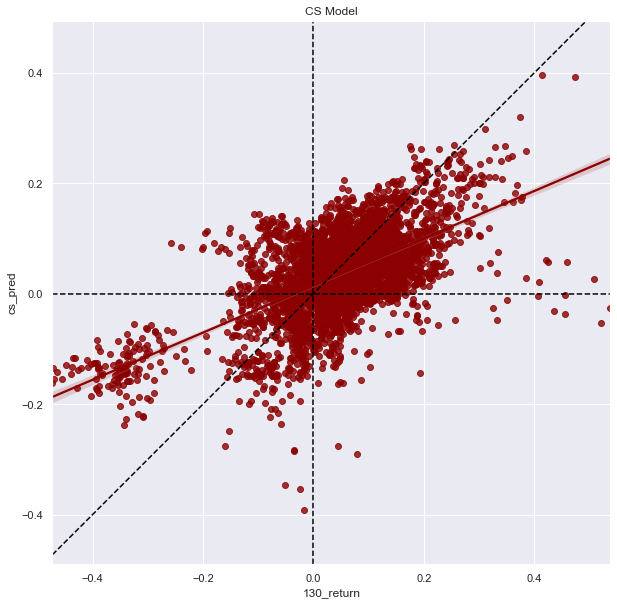

In [251]:
reg_plot(tmp, 'cs', 'darkred')

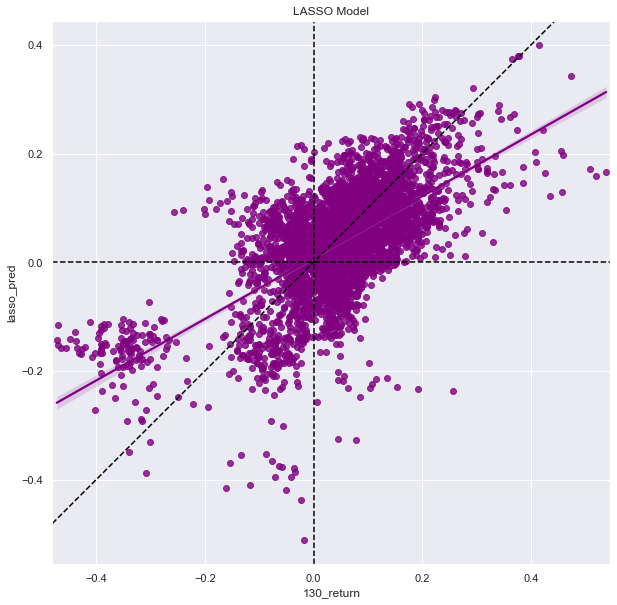

In [252]:
reg_plot(tmp, 'lasso', 'purple')